In [1]:
# set up the packages needed
import pandas as pd
import numpy as np
import nltk
import re
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import scipy.sparse as sp
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import chi2, SelectKBest
from collections import defaultdict 
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/lingyundai/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lingyundai/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# import training set
train_set = pd.read_csv('new_train.csv', header=None)
train_set

,0,1
0,-1,"Eat at Fioris, they said. Youll like it, they..."
1,-1,I just don't understand the appeal. I've trie...
2,1,This is my go to place for a really good beef ...
3,-1,"Not impressed. When I ordered the Oyako bowl, ..."
4,-1,This is the first time ever I wrote a bad revi...
...,...,...
17995,-1,I was referred to go to this place by a buddy ...
17996,1,The food here was really good. We started off...
17997,1,I eat at this place maybe 2-3 a week! I am die...
17998,1,Phoenix Airport is getting better day by day. ...


In [3]:
# import test set
test_set = pd.read_csv('new_test.csv', header=None)
test_set

,0
0,Got take-out from here last night and it was H...
1,Girls are sweet and prices are reasonable. The...
2,Rudest people I have ever encountered. Husban...
3,This airport is only coveted for the destinati...
4,The last 4 months have shown a steady decline ...
...,...
17995,I came here for dimsum with a few friends duri...
17996,I've been here a few times with our family. T...
17997,I went with a few friends and we split a few d...
17998,Great meal. Tom yum soup hits the spot on a co...


In [4]:
# check null value in train set
train_set.isnull().sum()

0    0
1    0
dtype: int64

In [5]:
# describe value in train set
train_set.describe()

,0
count,18000.000000
mean,0.000000
std,1.000028
min,-1.000000
25%,-1.000000
50%,0.000000
75%,1.000000
max,1.000000


In [6]:
# check null value in test set
test_set.isnull().sum()

0    0
dtype: int64

In [7]:
# describe value in test set
test_set.describe()

,0
count,18000
unique,18000
top,Got take-out from here last night and it was H...
freq,1


array([[<Axes: title={'center': '0'}>]], dtype=object)

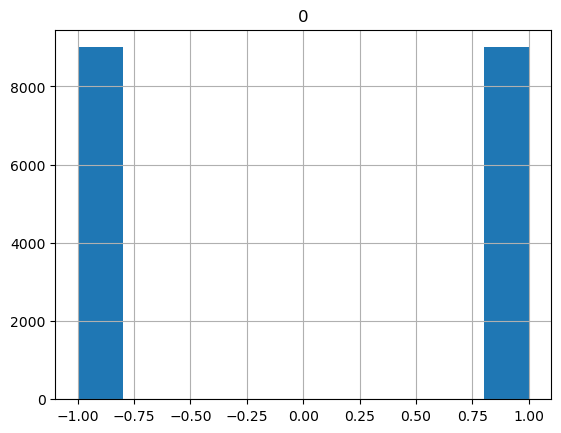

In [8]:
# check target class distribution
train_set.hist(column=0)

In [20]:
# split to train attributes
train_X = train_set.iloc[:, 1:2]
train_X

,1
0,"Eat at Fioris, they said. Youll like it, they..."
1,I just don't understand the appeal. I've trie...
2,This is my go to place for a really good beef ...
3,"Not impressed. When I ordered the Oyako bowl, ..."
4,This is the first time ever I wrote a bad revi...
...,...
17995,I was referred to go to this place by a buddy ...
17996,The food here was really good. We started off...
17997,I eat at this place maybe 2-3 a week! I am die...
17998,Phoenix Airport is getting better day by day. ...


In [10]:
# split to train target class
train_Y = train_set.iloc[:, 0:1]
train_Y = train_Y.replace(1, '+1')

In [22]:
# perform text preprocessing
# apply porter stemmer - 
# tokenize, remove punctuation and number, remove word contraction, remove stop words, stem

# stemming object
class Stemmer:
    def __init__(self):
        pass
    
    # tokenize words in each sentence in the arr
    def tokenize(self, arr):
        tokenizedRes = []
        # ignore single quote as well for accurate stop words removal later
        tokenizer = RegexpTokenizer(r"[A-Za-z']+")
        for sentence in arr:
            for words in sentence:
                # remove newline char for accurate stop words removal later
                stripWords = words.replace('\n', '')
                tokenizedWords = tokenizer.tokenize(stripWords)
            tokenizedRes.append(tokenizedWords)
#         print(tokenizedRes)
        return tokenizedRes
    
    # remove punctuation and numbers
    def removePuncAndNum(self, tokenizedRes):
        cleanedRes = []
        for item in tokenizedRes:
            cleanedItem = []
            for char in item:
                # replace non alphabetical char or space or single quote with ''
                cleanedItem.append(re.sub(r'[^a-zA-Z\s\']', '', char))
            cleanedItem = list(filter(None, cleanedItem))
#             print(cleanedItem)
            cleanedRes.append(cleanedItem)
        return cleanedRes
    
    # remove word contractions
    def removeContraction(self, cleanedRes):
        noContractionRes = []
        for item in cleanedRes:
            # remove contraction to ensure the correct sentiment
#             noContractionItem = [re.sub(r"n't", ' not', char) for char in item]
            noContractionItem = ['not' if "n't" in char else char for char in item]
            noContractionRes.append(noContractionItem)
#         print(noContractionRes)
        return noContractionRes
    
    # remove stop words
    def removeStopWords(self, noContractionRes):
        stopWords = set(stopwords.words('english'))
#         print(stopWords)
        # handle special outcome of contraction removal for "won't"
        stopWords.add("wo")
        # handle typos in text
        stopWords.add("youll")
        stopWords.add("im")
        stopWords.add("that's")
        stopWords.add("i've")
        # remove negative sentiment from stop words
        stopWords.remove("not")
        noStopWordsRes = []
        for item in noContractionRes:
            noStopWordsItem = []
            for char in item:
                char = char.lower()
                if char in stopWords:
                    char = char.replace(char, '')
                noStopWordsItem.append(char)
                noStopWordsItem = list(filter(None, noStopWordsItem))
            noStopWordsRes.append(noStopWordsItem)
#         print(noStopWordsRes)
        return noStopWordsRes
                
    # stem the tokenized result
    def stem(self, noStopWordsRes):
        stemmer = PorterStemmer()
        stemmedRes = []
        for res in noStopWordsRes:
            stemmedSentence = []
            for w in res:
                stemmedSentence.append(stemmer.stem(w))
            stemmedRes.append(stemmedSentence)
#         print(stemmedRes)
        return stemmedRes
    
    # merge stemmed res to vectorizer ready format
    def vectorizerReady(self, stemmedRes):
        vectorizedRes = []
        for item in stemmedRes:
            mergedSentence = ' '.join(item)
            vectorizedRes.append(mergedSentence)
#         print(vectorizedRes)
        return vectorizedRes
                
obj = Stemmer()
tokenizedRes = obj.tokenize(np.array(train_X))
cleanedRes = obj.removePuncAndNum(tokenizedRes)
noContractionRes = obj.removeContraction(cleanedRes)
noStopWordsRes = obj.removeStopWords(noContractionRes)
stemmedRes = obj.stem(noStopWordsRes)
vectorizedRes = obj.vectorizerReady(stemmedRes)

In [23]:
# stem test set
obj1 = Stemmer()
tokenizedResTest = obj1.tokenize(np.array(test_set))
cleanedResTest = obj1.removePuncAndNum(tokenizedResTest)
noContractionResTest = obj1.removeContraction(cleanedResTest)
noStopWordsResTest = obj1.removeStopWords(noContractionResTest)
stemmedResTest = obj1.stem(noStopWordsResTest)
vectorizedResTest = obj1.vectorizerReady(stemmedResTest)

["got take last night horribl someth must happen peopl work disorgan check food left order fajita littl meat beyond ridicul hardli pepper plethora look like stew tomato look i'm gringa know not look right could way better job rice miss complet one giant pizza pie look tortilla call person answer could bare speak english realli not big deal book manag around resolv situat ask email could send note experi unhelp offer us come back right hungri fianc not option get grumpi know better mess grumpi hungri pant",
 'girl sweet price reason stand bed hot make sure adjust time might super white lol',
 'rudest peopl ever encount husband wife own busi call servic wife unbeliev unnecessarili rude demand not wast time call',
 "airport covet destin lead flier view strip thing redeem hotel tacki slot machin center termin one thing dont even smoker' loung vega god' sake not mani option food airport also tini airport lot traffic traffic line doom catastrpoh defens drink line saw mani peopl",
 "last mont

In [24]:
# perform ti idf vectorize on train and test set
vectorizer = TfidfVectorizer()

# fit on training
vectorized_train_X = vectorizer.fit_transform(vectorizedRes)
vectorized_test = vectorizer.transform(vectorizedResTest)

# make sure both train and test hava the same shape
print(type(vectorized_train_X))
print(vectorized_train_X.shape)
print(type(vectorized_test))
print(vectorized_test.shape)

<class 'scipy.sparse._csr.csr_matrix'>
(18000, 26526)
<class 'scipy.sparse._csr.csr_matrix'>
(18000, 26526)


In [27]:
# perform chi-sqaured test to select feature on train
selectKBest = SelectKBest(chi2, k=13)
vectorized_scaled_train_X = selectKBest.fit_transform(vectorized_train_X, train_Y.values.flatten().astype(int))

# perform chi-sqaured test to select feature on test
vectorized_scaled_test = selectKBest.transform(vectorized_test)

In [28]:
# perform pca
# reduce training set dimension by applying PCA
# pick 5 principle components 
svd = TruncatedSVD(n_components=7)
# fit PCA on scaled student training data
vectorized_scaled_train_X = svd.fit_transform(vectorized_scaled_train_X)
# apply dimension reduction
vectorized_scaled_test = svd.transform(vectorized_scaled_test)
vectorized_scaled_train_X.shape

(18000, 7)

In [ ]:
# apply knn algorithm
# calculate distances between each test data query and all training data queries
# use hashmaps to match row indices and get majority votes for quick insertion and lookup
class NearestNeighbor:
    def __init__(self, k):
        self.k = k
    
    def knn(self, trainingData, testDataQuery, yTrain):
        totalDistanceArr = []
        count = {}
        targets = []
        # iterate thru each array in training data with row index and row array
        for rowIndex, trainRow in enumerate(vectorized_scaled_train_X.tolist()):
            # reset total distance every time we go to a new training set array
            totalDistance = 0
            # for each index, value in current array in training set
            for valIndex, value in enumerate(trainRow):
                # total distance is the sum of the subtractions of corresponding indices 
                # values in training array and test array
                totalDistance += np.square(value - testDataQuery[valIndex])
            # use hashmap to map the calculated euclidean distance 
            # to the row index in the training set
            count[float(np.sqrt(totalDistance))] = rowIndex
            # append the distances to a distance array
            totalDistanceArr.append(float(np.sqrt(totalDistance)))
            # sort distance array
            totalDistanceArr.sort()
        
        # get k number of distances from total distance array
        kDistance = totalDistanceArr[:self.k]
        
        # find the corresponding training set row based on the k number of distances
        for dist in kDistance:
            # append the indices to targets array
            targets.append(count[dist])
        
        # find the corresponding targets of the indices in y_train
        labels = [yTrain[i] for i in targets]
        # hashmap to count target amounts
        countLabels = {}
        for l in labels:
            countLabels[l] = 1 + countLabels.get(l, 0)
            # max value's key in hashmap is majority vote label
            maxLabel = max(countLabels, key=countLabels.get)
        return maxLabel

# testtrain = np.array([[5, 6, 7, 8, 9], [0, 1, 2, 3, 4], [10, 11, 12, 13, 14]])
# testtest = np.array([[-1, -2, -3, -4, -5], [0, 0, 0, 0, 0], [-6, -6, -6, -6, -6]])

13
-1
13
-1
13
-1
13
-1
13
-1
13
-1
13
-1
13
+1
13
-1
13
+1
13
-1
13
-1
13
-1
13
-1
13
-1
13
+1
13
-1
13
+1
13
+1
13
-1
13
-1
13
-1
13
-1
13
+1
13
+1
13
-1
13
+1
13
-1
13
-1
13
+1
13
-1
13
-1
13
+1
13
+1
13
-1
13
-1
13
-1
13
+1
13
-1
13
-1
13
-1
13
-1
13
-1
13
+1
13
-1
13
-1
13
+1
13
-1
13
-1
13
+1
13
+1
13
-1
13
-1
13
-1
13
+1
13
-1
13
-1
13
-1
13
+1
13
-1
13
-1
13
+1
13
-1
13
+1
13
-1
13
-1
13
-1
13
-1
13
+1
13
+1
13
+1
13
-1
13
-1
13
-1
13
+1
13
-1
13
-1
13
-1
13
+1
13
-1
13
+1
13
-1
13
+1
13
+1
13
-1
13
-1
13
+1
13
-1
13
-1
13
-1
13
+1
13
+1
13
-1
13
-1
13
+1
13
-1
13
-1
13
-1
13
+1
13
+1
13
-1
13
-1
13
+1
13
+1
13
-1
13
-1
13
-1
13
-1
13
-1
13
+1
13
+1
13
-1
13
+1
13
-1
13
-1
13
+1
13
-1
13
-1
13
-1
13
-1
13
+1
13
+1
13
-1
13
-1
13
-1
13
+1
13
+1
13
+1
13
+1
13
-1
13
-1
13
-1
13
-1
13
+1
13
-1
13
-1
13
-1
13
+1
13
-1
13
-1
13
+1
13
-1
13
+1
13
+1
13
-1
13
-1
13
+1
13
+1
13
-1
13
-1
13
-1
13
-1
13
-1
13
+1
13
+1
13
+1
13
-1
13
-1
13
-1
13
-1
13
-1
13
-1
13
-1
13
-1
13
-1
13
+1
13
+

13
-1
13
+1
13
+1
13
+1
13
+1
13
-1
13
+1
13
-1
13
-1
13
+1
13
-1
13
-1
13
+1
13
+1
13
+1
13
-1
13
+1
13
-1
13
-1
13
+1
13
-1
13
-1
13
-1
13
-1
13
+1
13
-1
13
-1
13
+1
13
-1
13
+1
13
+1
13
-1
13
-1
13
-1
13
-1
13
-1
13
+1
13
-1
13
-1
13
-1
13
-1
13
-1
13
-1
13
-1
13
+1
13
-1
13
-1
13
-1
13
+1
13
-1
13
+1
13
-1
13
-1
13
+1
13
+1
13
-1
13
-1
13
+1
13
+1
13
-1
13
+1
13
-1
13
+1
13
+1
13
+1
13
+1
13
-1
13
+1
13
-1
13
-1
13
+1
13
-1
13
-1
13
+1
13
+1
13
+1
13
+1
13
+1
13
-1
13
-1
13
+1
13
-1
13
+1
13
-1
13
+1
13
-1
13
+1
13
-1
13
+1
13
+1
13
-1
13
-1
13
-1
13
-1
13
-1
13
-1
13
+1
13
-1
13
+1
13
+1
13
-1
13
+1
13
+1
13
-1
13
-1
13
+1
13
-1
13
-1
13
+1
13
+1
13
-1
13
+1
13
-1
13
-1
13
-1
13
+1
13
+1
13
-1
13
-1
13
+1
13
+1
13
-1
13
+1
13
+1
13
+1
13
+1
13
+1
13
-1
13
+1
13
-1
13
-1
13
-1
13
-1
13
+1
13
+1
13
-1
13
-1
13
+1
13
+1
13
-1
13
-1
13
+1
13
-1
13
+1
13
-1
13
+1
13
+1
13
-1
13
-1
13
+1
13
+1
13
-1
13
+1
13
-1
13
+1
13
-1
13
+1
13
-1
13
+1
13
+1
13
+1
13
+1
13
+1
13
-1
13
+1
13
-1
13
-

13
+1
13
-1
13
-1
13
-1
13
+1
13
+1
13
-1
13
+1
13
-1
13
-1
13
-1
13
-1
13
+1
13
+1
13
-1
13
-1
13
-1
13
-1
13
-1
13
+1
13
+1
13
+1
13
-1
13
+1
13
-1
13
-1
13
+1
13
-1
13
+1
13
+1
13
-1
13
+1
13
-1
13
+1
13
-1
13
+1
13
-1
13
-1
13
+1
13
+1
13
+1
13
-1
13
+1
13
-1
13
-1
13
-1
13
-1
13
-1
13
+1
13
+1
13
+1
13
-1
13
-1
13
-1
13
-1
13
-1
13
-1
13
+1
13
-1
13
+1
13
-1
13
-1
13
-1
13
-1
13
+1
13
+1
13
-1
13
-1
13
-1
13
+1
13
-1
13
-1
13
-1
13
-1
13
+1
13
-1
13
-1
13
-1
13
-1
13
-1
13
-1
13
+1
13
-1
13
+1
13
+1
13
+1
13
-1
13
-1
13
-1
13
-1
13
-1
13
-1
13
-1
13
+1
13
+1
13
-1
13
-1
13
+1
13
+1
13
+1
13
+1
13
+1
13
-1
13
-1
13
-1
13
-1
13
-1
13
+1
13
-1
13
-1
13
-1
13
+1
13
-1
13
-1
13
-1
13
+1
13
+1
13
+1
13
-1
13
-1
13
-1
13
+1
13
-1
13
-1
13
+1
13
-1
13
+1
13
-1
13
+1
13
-1
13
-1
13
+1
13
-1
13
-1
13
-1
13
-1
13
-1
13
-1
13
+1
13
-1
13
-1
13
-1
13
-1
13
+1
13
-1
13
-1
13
+1
13
+1
13
+1
13
-1
13
-1
13
+1
13
+1
13
-1
13
-1
13
+1
13
-1
13
-1
13
+1
13
+1
13
+1
13
+1
13
+1
13
-1
13
+1
13
-1
13
+

13
+1
13
+1
13
+1
13
+1
13
+1
13
-1
13
-1
13
-1
13
+1
13
-1
13
-1
13
+1
13
-1
13
+1
13
-1
13
-1
13
+1
13
-1
13
-1
13
+1
13
+1
13
-1
13
-1
13
-1
13
-1
13
-1
13
-1
13
-1
13
-1
13
-1
13
-1
13
+1
13
+1
13
-1
13
-1
13
-1
13
-1
13
+1
13
+1
13
-1
13
-1
13
+1
13
+1
13
-1
13
-1
13
+1
13
+1
13
-1
13
-1
13
-1
13
-1
13
+1
13
-1
13
-1
13
-1
13
-1
13
+1
13
+1
13
-1
13
-1
13
-1
13
+1
13
-1
13
-1
13
-1
13
+1
13
-1
13
-1
13
-1
13
+1
13
-1
13
+1
13
+1
13
+1
13
-1
13
-1
13
-1
13
-1
13
-1
13
+1
13
+1
13
+1
13
-1
13
-1
13
-1
13
+1
13
-1
13
+1
13
+1
13
+1
13
-1
13
-1
13
+1
13
-1
13
-1
13
-1
13
-1
13
-1
13
-1
13
-1
13
-1
13
+1
13
-1
13
+1
13
-1
13
+1
13
-1
13
+1
13
-1
13
-1
13
+1
13
+1
13
+1
13
-1
13
-1
13
-1
13
+1
13
+1
13
-1
13
-1
13
+1
13
-1
13
-1
13
+1
13
-1
13
-1
13
-1
13
-1
13
-1
13
+1
13
+1
13
-1
13
-1
13
-1
13
+1
13
-1
13
-1
13
+1
13
+1
13
+1
13
-1
13
-1
13
-1
13
-1
13
-1
13
-1
13
-1
13
-1
13
-1
13
-1
13
-1
13
+1
13
-1
13
-1
13
-1
13
+1
13
+1
13
-1
13
+1
13
-1
13
-1
13
-1
13
-1
13
+1
13
+1
13
-1
13
-

13
-1
13
+1
13
-1
13
-1
13
-1
13
-1
13
-1
13
-1
13
-1
13
-1
13
-1
13
-1
13
+1
13
-1
13
-1
13
-1
13
-1
13
-1
13
+1
13
-1
13
-1
13
-1
13
+1
13
+1
13
+1
13
-1
13
-1
13
+1
13
-1
13
-1
13
-1
13
-1
13
-1
13
+1
13
-1
13
+1
13
-1
13
-1
13
+1
13
-1
13
+1
13
+1
13
-1
13
+1
13
-1
13
-1
13
+1
13
-1
13
-1
13
+1
13
+1
13
-1
13
-1
13
-1
13
-1
13
-1
13
-1
13
-1
13
+1
13
-1
13
-1
13
+1
13
+1
13
-1
13
-1
13
+1
13
+1
13
-1
13
-1
13
-1
13
-1
13
+1
13
+1
13
+1
13
-1
13
-1
13
-1
13
-1
13
-1
13
-1
13
+1
13
+1
13
+1
13
+1
13
+1
13
-1
13
-1
13
+1
13
-1
13
-1
13
-1
13
+1
13
-1
13
+1
13
+1
13
+1
13
+1
13
-1
13
-1
13
-1
13
-1
13
+1
13
-1
13
-1
13
-1
13
+1
13
-1
13
+1
13
+1
13
+1
13
+1
13
-1
13
+1
13
+1
13
-1
13
+1
13
-1
13
-1
13
-1
13
+1
13
+1
13
-1
13
+1
13
+1
13
+1
13
-1
13
-1
13
+1
13
-1
13
+1
13
-1
13
-1
13
+1
13
+1
13
-1
13
+1
13
-1
13
+1
13
-1
13
-1
13
+1
13
+1
13
-1
13
-1
13
-1
13
+1
13
-1
13
-1
13
+1
13
-1
13
-1
13
+1
13
-1
13
-1
13
+1
13
-1
13
-1
13
-1
13
+1
13
-1
13
-1
13
-1
13
+1
13
+1
13
-1
13
-1
13
-

In [ ]:
# apply k fold cross validation
# merge corresponding scaled training X with training Y
# apply k fold cross validation 
class kFoldCrossValidation:
    def __init__(self, k):
        self.k = k
        
    def mergeScaledXWithY(self, scaledTrainingX, trainingY):
        mergedArr = []
        Y_trainNp = train_Y.to_numpy()
        # combine scaled training X with training Y
        for i in range(len(vectorized_scaled_train_X.tolist())):
            # append target value to corresponding scaled training data
            new = np.append(vectorized_scaled_train_X[i], Y_trainNp[i])
            # append to a merged array
            mergedArr.append(new)
        #     print("merged arr, ", mergedArr)
        return mergedArr
    
    def applyKFold(self, mergedArr):
        # shuffle dataset every time before splitting
        np.random.shuffle(mergedArr)
        # split array into k parts
        splitArr = np.array_split(mergedArr, self.k)
        # k - 1 folds are training folds, concatenate arrays into one array
        trainingFolds = np.concatenate(splitArr[:self.k-1])
        # rest is test fold, concatenate arrays into one array
        testFolds = np.concatenate(splitArr[self.k-1:])

        # split independent variables and dependent variable for training sets
        trainingFoldsX = []
        trainingFoldsY = []
        for fold in trainingFolds:
            # everything but the last value
            trainingFoldsX.append(fold[:len(fold) - 1])
            # last value/target
            trainingFoldsY.append(fold[len(fold) - 1:])
        # convert trainingFoldsX to numpy array to suit algorithm
        trainingFoldsXNp = np.array(trainingFoldsX)
        # convert trainingFoldsY to dataframe to suit algorithm
        trainingFoldsYDf = pd.DataFrame(trainingFoldsY)

        # split independent variables and dependent variable for test set
        testingFoldsX = []
        testingFoldsY = []
        for fold in testFolds:
            testingFoldsX.append(fold[:len(fold) - 1])
            testingFoldsY.append(fold[len(fold) - 1:])
        
        # call knn alogorithm, assign k
        obj = NearestNeighbor(k=13)
        # classification results
        classificationRes = []
        # get majority votes for each test data query
        for testRow in testingFoldsX:
            # append the classification results
            classificationRes.append(obj.knn(trainingFoldsXNp, testRow, trainingFoldsYDf.to_numpy().flatten()))

        correctRes = 0
        # find out how many classifications are correct
        for i in range(len(testingFoldsY)):
            if int(testingFoldsY[i][0]) == classificationRes[i]:
                correctRes += 1
            # calculate the accuracy
            accuracy = correctRes / len(testingFoldsY)
        print("accuracy: ", accuracy)
        return accuracy

# tiny data set for testing purpose
# mockScaledTrainingX = np.array([[0.1, 0.2, 0.3, 0.4, 0.5],
#                                 [0.6, 0.7, 0.8, 0.9, 1.0],
#                                 [1.1, 1.2, 1.3, 1.4, 1.5],
#                                 [1.6, 1.7, 1.8, 1.9, 2.0],
#                                 [2.1, 2.2, 2.3, 2.4, 2.5],
#                                 [2.6, 2.7, 2.8, 2.9, 3.0]])
# mockTrainingY = np.array([[1],[3],[2],[1],[3],[2]])

# # calculate average accuracy after performing k-fold cross validation k times, assign k
# obj = kFoldCrossValidation(k=3)
# # get merged array
# mergedArr = obj.mergeScaledXWithY(vectorized_scaled_train_X, train_Y.to_numpy().flatten())
# print(obj.applyKFold(mergedArr))

In [ ]:
# calculate average accuracy after performing k-fold cross validation k times, assign k
obj = kFoldCrossValidation(k=11)
# get merged array
mergedArr = obj.mergeScaledXWithY(vectorized_scaled_train_X, train_Y)

# calculate accuracy k times
totalAccuracy = 0
for i in range(1, obj.k+1):
    totalAccuracy += obj.applyKFold(mergedArr)
    # get the final average accuracy
avgAccuracy = totalAccuracy / obj.k
print("avg accuracy: ", avgAccuracy)

In [ ]:
# apply knn

obj = NearestNeighbor(k=13)
# # # # obj.knn(np.array(testtrain), np.array(testtest1), testy)
for testRow in vectorized_scaled_test.tolist():
    print(obj.knn(vectorized_scaled_train_X, testRow, train_Y.to_numpy().flatten()))